# Eye Glasses Detection Model
# (Comparing Test-Train Split Ratios)

## Import required libraries

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras

## Loading dataset from image directory

In [11]:
train_set = []
train_set = tf.keras.preprocessing.image_dataset_from_directory('short_data_self',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(299, 299),
    shuffle=True, 
    seed=100,
    validation_split=None, 
    subset=None,
    interpolation='bilinear', 
    follow_links=False)

Found 46372 files belonging to 2 classes.


Found 46372 files belonging to 2 classes.


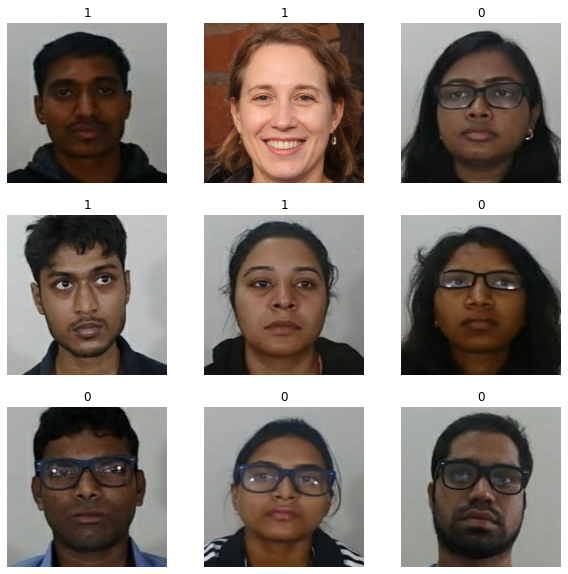

In [12]:
train = []
train = tf.keras.preprocessing.image_dataset_from_directory('short_data_self',
    labels="inferred",
    label_mode="int",
    image_size=(299, 299),
    shuffle=True,
    seed=100
    )
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
real_data = []
real_data = tf.keras.preprocessing.image_dataset_from_directory('test_data',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(299, 299),
    shuffle=True, 
    seed=None,
    validation_split=None, 
    subset=None,
    interpolation='bilinear', 
    follow_links=False)

Found 227 files belonging to 2 classes.


Found 227 files belonging to 2 classes.


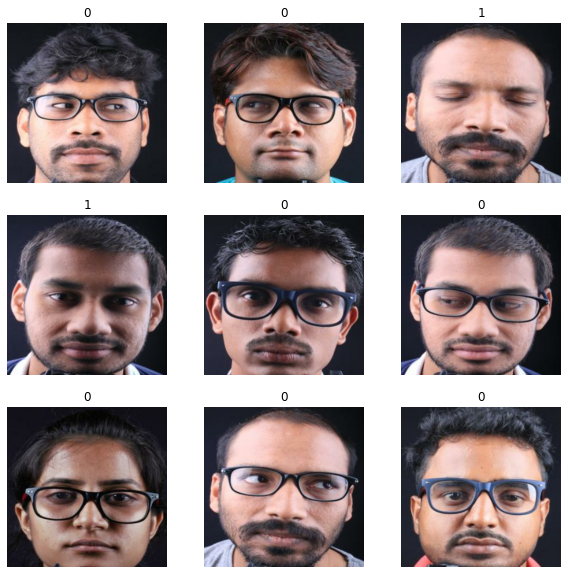

In [14]:
real = []
real = tf.keras.preprocessing.image_dataset_from_directory('test_data',
    labels="inferred",
    label_mode="int",
    image_size=(299, 299),
    shuffle=True                                                        
    )
plt.figure(figsize=(10, 10))
for images, labels in real.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

##### To use these data for training and refactoring the pre-trained model we have to resize and claibrate the images according to the model (it should match with the congfiguration of images used for training the mobile_net model)

In [15]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [16]:
train_set = train_set.map(process)
dlen = len(train_set)
print("Length of Dataset(Batch size - 16) -", dlen)

Length of Dataset(Batch size - 16) - 2899


In [17]:
real_data = real_data.map(process)
dlen = len(real_data)
print("Length of Random Test Dataset(Batch size - 1) -", dlen)

Length of Random Test Dataset(Batch size - 1) - 227


# Investigating Different Test-Train Split Ratio's Performance

### 80-20 Split

In [18]:
test_len = int(len(train_set)*0.2)
test_data = train_set.take(test_len)
train_data = train_set.skip(test_len)
print("Length of Training Dataset -", len(train_data))
print("Length of Testing Dataset -", len(test_data))

Length of Training Dataset - 2320
Length of Testing Dataset - 579


## Defining and Training the model using different Optimizers functions

We have to define a multilayer neural network using the layers of our pre-trained model and add a Dropout Layer as well as a Dense Layer (a layer that receives input from all the neurons present in the previous layer) with 2 neurons as our prediction class includes only two distinct values

### Adam Optimizer

In [19]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [20]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [21]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [22]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

C:\Users\Anshi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Anshi\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


2320/2320 [==============================] - 1720s 735ms/step - loss: 0.1718 - acc: 0.9884


In [23]:
results = model.evaluate(test_data)
print("Test Accuracy for Adam Optimizer is %s " %results[1])

579/579 [==============================] - 414s 713ms/step - loss: 0.0400 - acc: 0.9986
Test Accuracy for 80-20 split is 0.998596727848053 


In [24]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 84ms/step - loss: 0.0000e+00 - acc: 1.0000


[0.0, 1.0]

In [43]:
loss_adam = np.array(Batch_History.batch_loss)
acc_adam = np.array(Batch_History.batch_accuracy)

In [44]:
np.save("model optimizers/adam/adam_loss", loss_adam)
np.save("model optimizers/adam/adam_acc", acc_adam)

In [45]:
model.save("model optimizers/adam/model.h5")

In [46]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [47]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [48]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [49]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1699s 726ms/step - loss: 0.4148 - acc: 0.9880


In [50]:
results = model.evaluate(test_data)
print("Test Accuracy for SGD Optimier is %s " %results[1])

579/579 [==============================] - 412s 710ms/step - loss: 0.0387 - acc: 0.9960
Test Accuracy for SGD Optimier is 0.9960060715675354 


In [51]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 83ms/step - loss: 0.0269 - acc: 0.9956


[0.02690267376601696, 0.9955947399139404]

In [52]:
loss_sgd = np.array(Batch_History.batch_loss)
acc_sgd = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/sgd/sgd_loss", loss_sgd)
np.save("model optimizers/sgd/sgd_acc", acc_sgd)

model.save("model optimizers/sgd/model.h5")

In [57]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [58]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [59]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [60]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1690s 723ms/step - loss: 0.2468 - acc: 0.9874


In [61]:
results = model.evaluate(test_data)
print("Test Accuracy for RMS Optmizer is %s " %results[1])

579/579 [==============================] - 409s 704ms/step - loss: 0.0091 - acc: 0.9994
Test Accuracy for RMS Optmizer is 0.9993523359298706 


In [62]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 18s 80ms/step - loss: 1.5520e-05 - acc: 1.0000


[1.552025059936568e-05, 1.0]

In [63]:
loss_rms = np.array(Batch_History.batch_loss)
acc_rms = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/rms/rms_loss", loss_rms)
np.save("model optimizers/rms/rms_acc", acc_rms)

model.save("model optimizers/rms/model.h5")

In [64]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [65]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [66]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [67]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1690s 722ms/step - loss: 0.0356 - acc: 0.9923


In [68]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 411s 708ms/step - loss: 0.0025 - acc: 0.9995
Test Accuracy for AdaGrad Optimizer is 0.9994602799415588 


In [69]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 82ms/step - loss: 0.0012 - acc: 1.0000


[0.0011994752567261457, 1.0]

In [70]:
loss_adagrad = np.array(Batch_History.batch_loss)
acc_adagrad = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/adagrad_loss", loss_adagrad)
np.save("model optimizers/adagrad/adagrad_acc", acc_adagrad)

model.save("model optimizers/adagrad/model.h5")

In [153]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [154]:
model.compile(
    optimizer = tf.keras.optimizers.Adadelta(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [155]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [156]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1701s 727ms/step - loss: 0.3248 - acc: 0.8543


In [157]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaDelta Optimizer is %s " %results[1])

579/579 [==============================] - 423s 728ms/step - loss: 0.1016 - acc: 0.9714
Test Accuracy for AdaDelta Optimizer is 0.9713946580886841 


In [158]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 86ms/step - loss: 0.0980 - acc: 0.9780


[0.09797752648591995, 0.9779735803604126]

In [159]:
loss_adadelta = np.array(Batch_History.batch_loss)
acc_adadelta = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adadelta/adadelta_loss", loss_adadelta)
np.save("model optimizers/adadelta/adadelta_acc", acc_adadelta)

model.save("model optimizers/adadelta/model.h5")

In [168]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [169]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=1.0),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [170]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [171]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1701s 727ms/step - loss: 21.2992 - acc: 0.9915


In [172]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 429s 738ms/step - loss: 1.0181 - acc: 0.9990
Test Accuracy for AdaGrad Optimizer is 0.9990285038948059 


In [173]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 20s 86ms/step - loss: 0.0000e+00 - acc: 1.0000


[0.0, 1.0]

In [176]:
loss_adagrad_1 = np.array(Batch_History.batch_loss)
acc_adagrad_1 = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/lr1/adagrad_loss", loss_adagrad_1)
np.save("model optimizers/adagrad/lr1/adagrad_acc", acc_adagrad_1)

model.save("model optimizers/adagrad/lr1/model.h5")

In [177]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [178]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [179]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [180]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1702s 728ms/step - loss: 1.9910 - acc: 0.9913


In [181]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 419s 722ms/step - loss: 0.1283 - acc: 0.9990
Test Accuracy for AdaGrad Optimizer is 0.9990285038948059 


In [182]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 84ms/step - loss: 0.0000e+00 - acc: 1.0000


[0.0, 1.0]

In [183]:
loss_adagrad_01 = np.array(Batch_History.batch_loss)
acc_adagrad_01 = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/lr01/adagrad_loss", loss_adagrad_01)
np.save("model optimizers/adagrad/lr01/adagrad_acc", acc_adagrad_01)

model.save("model optimizers/adagrad/lr01/model.h5")

In [184]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [185]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [186]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [187]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1741s 745ms/step - loss: 0.1940 - acc: 0.9921


In [188]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 415s 714ms/step - loss: 0.0224 - acc: 0.9970
Test Accuracy for AdaGrad Optimizer is 0.9969775676727295 


In [189]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 85ms/step - loss: 3.3084e-08 - acc: 1.0000 2s 


[3.308439389115847e-08, 1.0]

In [190]:
loss_adagrad_001 = np.array(Batch_History.batch_loss)
acc_adagrad_001 = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/lr001/adagrad_loss", loss_adagrad_001)
np.save("model optimizers/adagrad/lr001/adagrad_acc", acc_adagrad_001)

model.save("model optimizers/adagrad/lr001/model.h5")

In [191]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [192]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [193]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [194]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1706s 730ms/step - loss: 0.0327 - acc: 0.9917


In [195]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 413s 712ms/step - loss: 0.0023 - acc: 0.9997
Test Accuracy for AdaGrad Optimizer is 0.9996761679649353 


In [199]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 82ms/step - loss: 0.0010 - acc: 1.0000


[0.001037495443597436, 1.0]

In [197]:
loss_adagrad_0001 = np.array(Batch_History.batch_loss)
acc_adagrad_0001 = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/lr0001/adagrad_loss", loss_adagrad_0001)
np.save("model optimizers/adagrad/lr0001/adagrad_acc", acc_adagrad_0001)

model.save("model optimizers/adagrad/lr0001/model.h5")

In [200]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [201]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ['acc'])

In [202]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [203]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1732s 741ms/step - loss: 0.0913 - acc: 0.9681


In [204]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 418s 720ms/step - loss: 0.0249 - acc: 0.9947
Test Accuracy for AdaGrad Optimizer is 0.9947106838226318 


In [205]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 83ms/step - loss: 0.0083 - acc: 1.0000


[0.008278751745820045, 1.0]

In [206]:
loss_adagrad_00001 = np.array(Batch_History.batch_loss)
acc_adagrad_00001 = np.array(Batch_History.batch_accuracy)

np.save("model optimizers/adagrad/lr00001/adagrad_loss", loss_adagrad_00001)
np.save("model optimizers/adagrad/lr00001/adagrad_acc", acc_adagrad_00001)

model.save("model optimizers/adagrad/lr00001/model.h5")

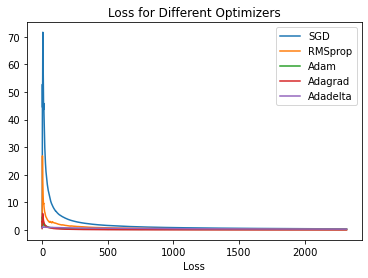

In [280]:
plt.plot(loss_sgd, label = "SGD")
plt.plot(loss_rms, label = "RMSprop")
plt.plot(loss_adam, label = "Adam")
plt.plot(loss_adagrad, label = "Adagrad")
plt.plot(loss_adadelta, label = "Adadelta")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Optimizers")
plt.show()

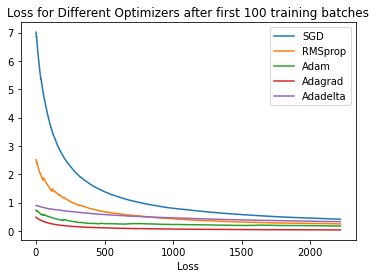

In [281]:
plt.plot(loss_sgd[100:], label = "SGD")
plt.plot(loss_rms[100:], label = "RMSprop")
plt.plot(loss_adam[100:], label = "Adam")
plt.plot(loss_adagrad[100:], label = "Adagrad")
plt.plot(loss_adadelta[100:], label = "Adadelta")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Optimizers after first 100 training batches")
plt.savefig('graph.jpg', dpi=800)   
plt.show()

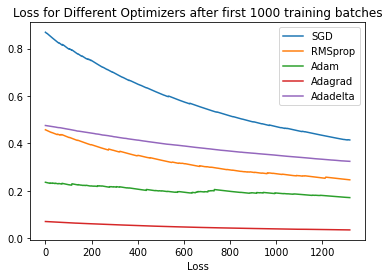

In [282]:
plt.plot(loss_sgd[1000:], label = "SGD")
plt.plot(loss_rms[1000:], label = "RMSprop")
plt.plot(loss_adam[1000:], label = "Adam")
plt.plot(loss_adagrad[1000:], label = "Adagrad")
plt.plot(loss_adadelta[1000:], label = "Adadelta")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Optimizers after first 1000 training batches")
plt.show()

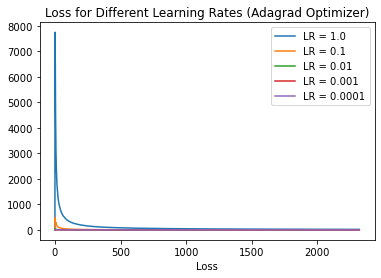

In [279]:
plt.plot(loss_adagrad_1, label = "LR = 1.0")
plt.plot(loss_adagrad_01, label = "LR = 0.1")
plt.plot(loss_adagrad_001, label = "LR = 0.01")
plt.plot(loss_adagrad_0001, label = "LR = 0.001")
plt.plot(loss_adagrad_00001, label = "LR = 0.0001")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Learning Rates (Adagrad Optimizer)")
plt.show()

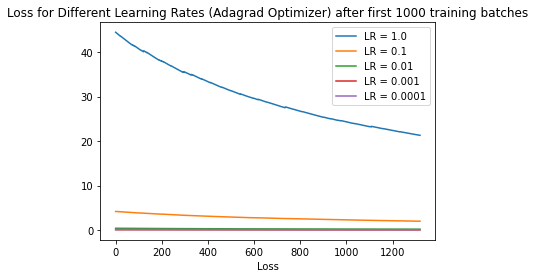

In [283]:
plt.plot(loss_adagrad_1[1000:], label = "LR = 1.0")
plt.plot(loss_adagrad_01[1000:], label = "LR = 0.1")
plt.plot(loss_adagrad_001[1000:], label = "LR = 0.01")
plt.plot(loss_adagrad_0001[1000:], label = "LR = 0.001")
plt.plot(loss_adagrad_00001[1000:], label = "LR = 0.0001")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Learning Rates (Adagrad Optimizer) after first 1000 training batches")
plt.show()

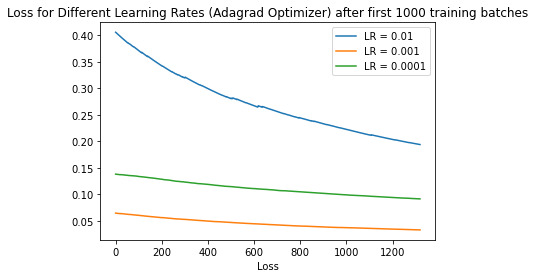

In [284]:
plt.plot(loss_adagrad_001[1000:], label = "LR = 0.01")
plt.plot(loss_adagrad_0001[1000:], label = "LR = 0.001")
plt.plot(loss_adagrad_00001[1000:], label = "LR = 0.0001")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Learning Rates (Adagrad Optimizer) after first 1000 training batches")
plt.show()

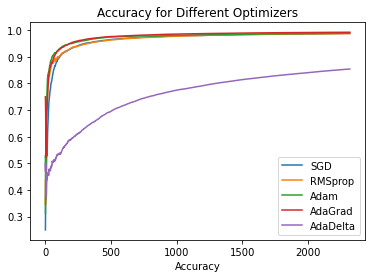

In [291]:
plt.plot(acc_sgd, label = "SGD")
plt.plot(acc_rms, label = "RMSprop")
plt.plot(acc_adam, label = "Adam")
plt.plot(acc_adagrad, label = "AdaGrad")
plt.plot(acc_adadelta, label = "AdaDelta")
plt.legend()
plt.xlabel("Accuracy")
plt.title("Accuracy for Different Optimizers")
plt.show()

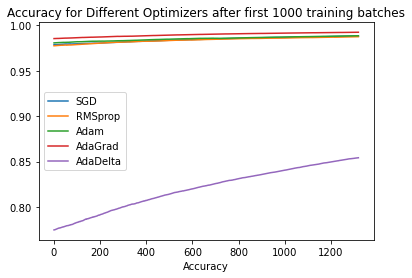

In [292]:
plt.plot(acc_sgd[1000:], label = "SGD")
plt.plot(acc_rms[1000:], label = "RMSprop")
plt.plot(acc_adam[1000:], label = "Adam")
plt.plot(acc_adagrad[1000:], label = "AdaGrad")
plt.plot(acc_adadelta[1000:], label = "AdaDelta")
plt.legend()
plt.xlabel("Accuracy")
plt.title("Accuracy for Different Optimizers after first 1000 training batches")
plt.show()

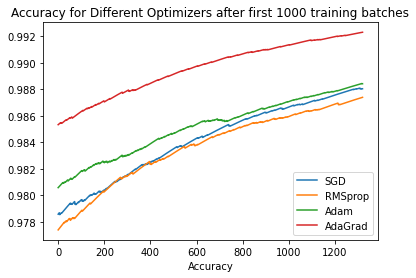

In [293]:
plt.plot(acc_sgd[1000:], label = "SGD")
plt.plot(acc_rms[1000:], label = "RMSprop")
plt.plot(acc_adam[1000:], label = "Adam")
plt.plot(acc_adagrad[1000:], label = "AdaGrad")
plt.legend()
plt.xlabel("Accuracy")
plt.title("Accuracy for Different Optimizers after first 1000 training batches")
plt.show()

# Activation Function for the Last Layer

In [299]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='sigmoid')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [300]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['acc'])

In [301]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [302]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1720s 735ms/step - loss: 0.0327 - acc: 0.9928


In [303]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 413s 710ms/step - loss: 0.0038 - acc: 0.9991
Test Accuracy for AdaGrad Optimizer is 0.9991364479064941 


In [304]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 83ms/step - loss: 5.7646e-04 - acc: 1.0000


[0.0005764590459875762, 1.0]

In [305]:
loss_sigmoid = np.array(Batch_History.batch_loss)
acc_sigmoid = np.array(Batch_History.batch_accuracy)

np.save("act func/sigmoid/sigmoid_loss", loss_sigmoid)
np.save("act func/sigmoid/sigmoid_acc", acc_sigmoid)

model.save("act func/sigmoid/model.h5")

In [306]:
model = tf.keras.applications.InceptionV3( weights = "imagenet",
                                           include_top = False,
                                           input_shape = (299,299,3)
                                         )
for layer in model.layers:
    layer.trainable = False
ex_layer = model.output
ex_layer = tf.keras.layers.Flatten()(ex_layer)
ex_layer = tf.keras.layers.Dropout(0.5)(ex_layer)
output = tf.keras.layers.Dense(2, activation='softmax')(ex_layer)
model = tf.keras.models.Model(inputs = model.input, outputs=output)

In [307]:
model.compile(
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['acc'])

In [308]:
class Batch_History(keras.callbacks.Callback):
    batch_accuracy = [] 
    batch_loss = []     
    def __init__(self):
        super(Batch_History,self).__init__() 
    def on_train_batch_end(self, batch, logs=None):                
        
        Batch_History.batch_accuracy.append(logs.get('acc'))
        Batch_History.batch_loss.append(logs.get('loss'))

In [309]:
model.fit_generator(train_data, epochs=1, validation_data = None, callbacks=[Batch_History()])

2320/2320 [==============================] - 1708s 729ms/step - loss: 0.0326 - acc: 0.9928


In [310]:
results = model.evaluate(test_data)
print("Test Accuracy for AdaGrad Optimizer is %s " %results[1])

579/579 [==============================] - 415s 715ms/step - loss: 0.0026 - acc: 0.9995
Test Accuracy for AdaGrad Optimizer is 0.9994602799415588 


In [311]:
results = model.evaluate(real_data)
results

227/227 [==============================] - 19s 84ms/step - loss: 4.7604e-04 - acc: 1.0000


[0.0004760391020681709, 1.0]

In [312]:
loss_softmax = np.array(Batch_History.batch_loss)
acc_softmax = np.array(Batch_History.batch_accuracy)

np.save("act func/softmax/softmax_loss", loss_softmax)
np.save("act func/softmax/softmax_acc", acc_softmax)

model.save("act func/softmax/model.h5")

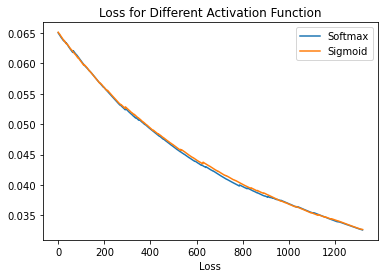

In [316]:
plt.plot(loss_softmax[1000:], label = "Softmax")
plt.plot(loss_sigmoid[1000:], label = "Sigmoid")
plt.legend()
plt.xlabel("Loss")
plt.title("Loss for Different Activation Function")
plt.show()